# Task 1 : Setup GPU Runtime Environment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
 !git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (3/3), done.


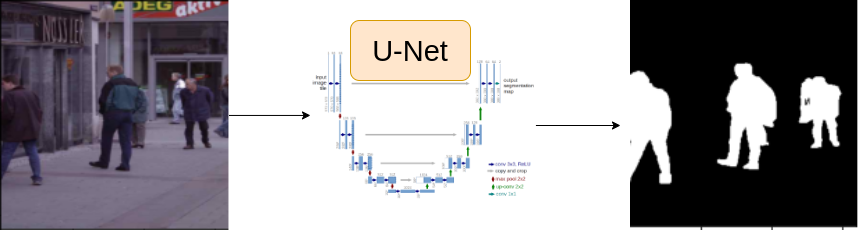

# Some Common Imports

In [4]:
import sys
sys.path.append('/kaggle/working/Human-Segmentation-Dataset-master')

In [5]:
pip install "numpy>=1.16.5,<1.23.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 50.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.82 requires numpy>=1.25.0, but you have numpy 1.22.4 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which is incompatible.
cudf 23.

In [6]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Task : 2 Setup Configurations

In [7]:
# Path to the CSV file containing training data
CSV_FILE = '/kaggle/working/Human-Segmentation-Dataset-master/train.csv'

# Directory path for the dataset
DATA_DIR = '/kaggle/working/Human-Segmentation-Dataset-master'

# Device to be used for computation
DEVICE = 'cuda'

# Number of training epochs
EPOCHS = 25

# Learning rate for the optimization algorithm
LR = 0.003

# Size of the input images
IMG_SIZE = 384

# Batch size for training
BATCH_SIZE = 16

# Encoder model architecture
ENCODER = 'time-efficientnet-b0'

# Pre-trained weights to be used
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [9]:
row = df.iloc[4]  # Get the 5th row from the DataFrame

image_path = row.images  # Get the image path from the 'images' column of the row
mask_path = row.masks  # Get the mask path from the 'masks' column of the row

image = cv2.imread(image_path)  # Read the image from the image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB color space

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Read the mask as a grayscale image and normalize it between 0 and 1

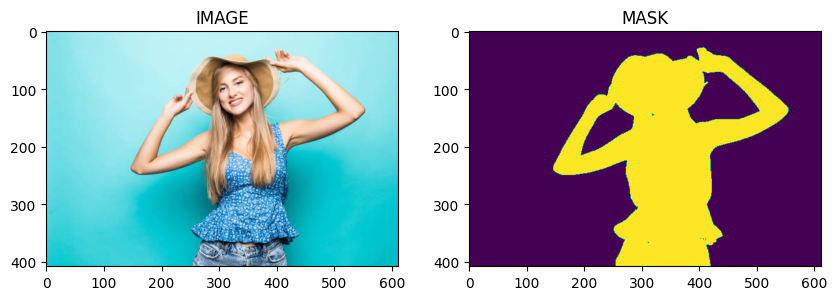

In [10]:
# Create a figure with two subplots side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Set a title for the first subplot
ax1.set_title('IMAGE')

# Display the image in the first subplot
ax1.imshow(image)

# Set a title for the second subplot
# ax2.set_title('GROUND TRUTH')

# Display the mask in the second subplot
# ax2.imshow(mask,cmap = 'gray')

# Set a title for the second subplot
ax2.set_title('MASK')

# Display the mask in the second subplot
ax2.imshow(mask)

In [11]:
# Split the DataFrame into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
    # Define an augmentation pipeline for training data
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),  # Resize the image to a specific size
        A.HorizontalFlip(p=0.5),  # Perform horizontal flips with a 50% probability
        A.VerticalFlip(p=0.5)  # Perform vertical flips with a 50% probability
    ], is_check_shapes=False)

def get_valid_augs():
    # Define an augmentation pipeline for validation data
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)  # Resize the image to a specific size
    ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [15]:
# Define a custom dataset class for segmentation tasks
class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Retrieve the image and mask paths from the dataframe
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks
        
        # Load and process the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load and process the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        
        # Apply augmentations if provided
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask, is_check_shapes=False)
            image = augmented['image']
            mask = augmented['mask']
            
        # Transform the image and mask into the appropriate format and type
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
            
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)
            
        # Return the image and mask as tensors
        return image, mask

In [16]:
# Create trainset object using SegmentationDataset class
trainset = SegmentationDataset(train_df, get_train_augs())

# Create validset object using SegmentationDataset class
validset = SegmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


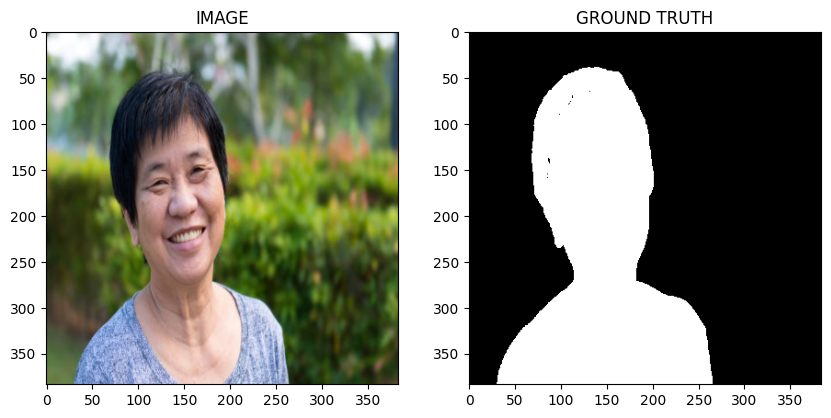

In [18]:
idx = 3

# Retrieve image and mask from trainset dataset
image, mask = trainset[idx]

# Display the image and mask
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
# Create a data loader for training data with specified batch size and shuffling
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for validation data with specified batch size
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [21]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [22]:
for image, mask in trainloader:  # Iterate over the trainloader
    break  # Stop after the first iteration
    
# Print the shape of the images and masks
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 384, 384])
One batch mask shape : torch.Size([16, 1, 384, 384])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [23]:
pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=cdfc11696cc376979f3b64e2b0df67e83009c6027650180223eefa4a5231ad30
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ce16458d5176f0042a87fa6d1aeae395975a899850de66c562102800dd25420a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing install

In [24]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [25]:
import segmentation_models_pytorch as smp

class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        # Initialize the U-Net model
        self.arc = smp.Unet(
            encoder_name="resnet34",  # Used a supported encoder name
            encoder_weights=WEIGHTS,  # Weight variable not defined in code snippet
            in_channels=3,  # Input image has 3 channels (e.g., RGB)
            classes=1,  # Model will output a single-channel mask
            activation=None  # No activation function applied to output
        )
        
    def forward(self, image, masks=None):
        # Pass the image tensor through the U-Net model
        logits = self.arc(image)
        
        if masks is not None:
            # Calculate loss using DiceLoss and BCEWithLogitsLoss
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            
            # Return logits and the sum of the two loss values
            return logits, loss1 + loss2
        
        # Return only the logits
        return logits

In [26]:
model = SegmentationModel()  # Create an instance of the SegmentationModel class
model.to(DEVICE);  # Move the model to the specified device

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 99.0MB/s]


# Task 7 : Create Train and Validation Function

In [27]:
def train_fn(data_loader, model, optimizer):

    # Set the model in training mode
    model.train()

    # Initialize variable to keep track of total loss
    total_loss = 0.0

    # Iterate over data loader
    for images, masks in tqdm(data_loader):

        # Move images to DEVICE
        images = images.to(DEVICE)

        # Move masks to DEVICE if not None
        if masks is not None:
            masks = masks.to(DEVICE)
        else:
            masks = None

        # Clear gradients of optimizer
        optimizer.zero_grad()

        # Calculate logits and loss
        logits, loss = model(images, masks)

        # Check if masks tensor is None
        if masks is not None:
            assert logits.size(0) == masks.size(0)

        # Perform backward pass to compute gradients
        loss.backward()

        # Update model's parameters
        optimizer.step()

        # Add current batch's loss to total loss
        total_loss += loss.item()

    # Return average loss across all batches
    return total_loss / len(data_loader)

In [28]:
def eval_fn(data_loader, model):

    # Set the model to evaluation mode
    model.eval()
    
    # Initialize the cumulative loss
    total_loss = 0.0

    # Iterate over the data loader
    for images, masks in tqdm(data_loader):

        # Move images to the specified device
        images = images.to(DEVICE)

        # Move masks to the specified device, or set to None if masks are None
        if masks is not None:
            masks = masks.to(DEVICE)
        else:
            masks = None

        # Perform forward pass through the model without gradient tracking
        with torch.no_grad():
            logits, loss = model(images, masks)

        # Check if the masks tensor is not None
        if masks is not None:
            assert logits.size(0) == masks.size(0)

        # Accumulate the loss
        total_loss += loss.item()

    # Return the average loss per batch
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [29]:
# Initialize an Adam optimizer for the given model with a learning rate LR
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [30]:
import torch

best_valid_loss = float('inf')  # Initialize with positive infinity

for epoch in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)  # Perform training
    valid_loss = eval_fn(validloader, model)  # Perform evaluation

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/kaggle/working/Human-Segmentation-Dataset-master/best_model.pt')  # Save the model
        
        # Print a message to indicate that the model has been saved
        print("SAVE-MODEL")

    # Print the epoch number, train loss, and validation loss
    print(f"Epoch : {epoch + 1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


SAVE-MODEL
Epoch : 1 Train_loss : 1.1657387812932332 Valid_loss : 21.58376979827881


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


SAVE-MODEL
Epoch : 2 Train_loss : 1.003842822710673 Valid_loss : 1.6637899577617645


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


SAVE-MODEL
Epoch : 3 Train_loss : 0.8600350141525268 Valid_loss : 1.1224969625473022


100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


SAVE-MODEL
Epoch : 4 Train_loss : 0.8073739091555278 Valid_loss : 0.8392748534679413


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


SAVE-MODEL
Epoch : 5 Train_loss : 0.803251039981842 Valid_loss : 0.794581726193428


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Epoch : 6 Train_loss : 0.7339874267578125 Valid_loss : 0.8696707487106323


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Epoch : 7 Train_loss : 0.6797987063725789 Valid_loss : 1.0896357744932175


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch : 8 Train_loss : 0.7441806594530741 Valid_loss : 1.5751686096191406


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Epoch : 9 Train_loss : 0.7072140574455261 Valid_loss : 0.8732600510120392


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


SAVE-MODEL
Epoch : 10 Train_loss : 0.6439284801483154 Valid_loss : 0.6820033490657806


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch : 11 Train_loss : 0.6151098251342774 Valid_loss : 1.002244770526886


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Epoch : 12 Train_loss : 0.6410995841026306 Valid_loss : 0.9654985815286636


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Epoch : 13 Train_loss : 0.6477049827575684 Valid_loss : 0.693523719906807


100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Epoch : 14 Train_loss : 0.6471698641777038 Valid_loss : 0.8389954268932343


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch : 15 Train_loss : 0.6137735227743785 Valid_loss : 0.951241746544838


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


SAVE-MODEL
Epoch : 16 Train_loss : 0.6176844378312428 Valid_loss : 0.6639246940612793


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Epoch : 17 Train_loss : 0.6087949832280477 Valid_loss : 0.7492502927780151


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch : 18 Train_loss : 0.5946117142836252 Valid_loss : 0.8243418037891388


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Epoch : 19 Train_loss : 0.5936535080273946 Valid_loss : 1.0222719758749008


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Epoch : 20 Train_loss : 0.5676981468995412 Valid_loss : 0.9985816925764084


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Epoch : 21 Train_loss : 0.5673864761988322 Valid_loss : 0.7070668041706085


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


SAVE-MODEL
Epoch : 22 Train_loss : 0.5826125204563141 Valid_loss : 0.6214885115623474


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch : 23 Train_loss : 0.5637321313222249 Valid_loss : 0.6514967232942581


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch : 24 Train_loss : 0.5901832421620686 Valid_loss : 0.7104530036449432


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

Epoch : 25 Train_loss : 0.6031172096729278 Valid_loss : 0.7513003498315811


# Task 9 : Inference

In [31]:
idx = 2

# Load the pre-trained model from the specified path
model.load_state_dict(torch.load('/kaggle/working/Human-Segmentation-Dataset-master/best_model.pt'))

# Retrieve the image and mask from the validation dataset at the given index
image, mask = validset[idx]

# Process the image using the model to obtain the logits for the mask
logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)

# Apply the sigmoid function to the logits to obtain the predicted mask probabilities
pred_mask = torch.sigmoid(logits_mask)

# Threshold the predicted mask probabilities at 0.5 to obtain a binary mask
pred_mask = (pred_mask > 0.5)*1.0

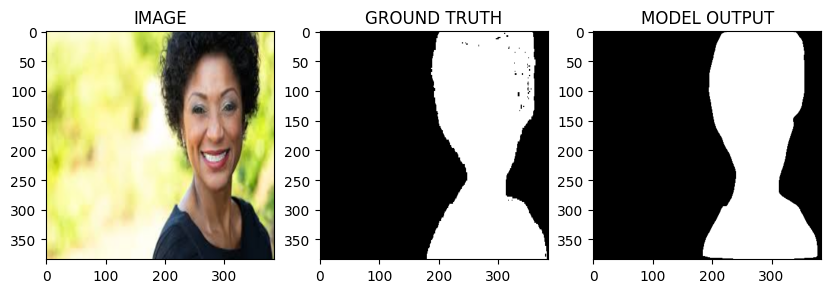

In [32]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))